In [31]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [32]:
import os

folder = "/content/drive/MyDrive/AFM"
for f in os.listdir(folder):
    print(f)

F-F_Research_Data_5_Factors_2x3_daily_CSV.zip
Archive.zip
F-F_Research_Data_Factors_daily_CSV.zip
F-F_Momentum_Factor_daily_CSV.zip


In [33]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from pathlib import Path
import zipfile
import pandas as pd
import numpy as np

base=Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)
for p in base.iterdir():
    if p.suffix.lower()==".zip":
        try:
            with zipfile.ZipFile(p,"r") as z:
                z.extractall(base)
        except:
            pass

csv_files=[]
for root,dirs,files in os.walk(base):
    for f in files:
        if f.lower().endswith(".csv"):
            csv_files.append(os.path.join(root,f))

def try_read_csv(path):
    for col in ("date","Date","DATE","Year","DATE_"):
        try:
            df=pd.read_csv(path,parse_dates=[col])
            df.index=pd.to_datetime(df[col])
            return df
        except Exception:
            pass
    try:
        df=pd.read_csv(path,parse_dates=True, infer_datetime_format=True)
        if df.shape[1]>0 and df.columns[0].lower() in ("date","index","year"):
            df=df.set_index(df.columns[0])
        df.index=pd.to_datetime(df.index)
        return df
    except Exception:
        return None

factor_dfs=[]
seen=set()
for f in csv_files:
    fname=os.path.basename(f).lower()
    if "ff_research" in fname or "f-f" in fname or "momentum" in fname or "f_f" in fname or "fama" in fname:
        df=try_read_csv(f)
        if df is not None:
            df=df.rename(columns={c:c.strip() for c in df.columns})
            df.columns=[c.lower() for c in df.columns]
            if 'date' in df.columns:
                df=df.set_index(pd.to_datetime(df['date']))
            factor_dfs.append((f,df))
            seen.add(f)

if not factor_dfs:
    for f in csv_files:
        df=try_read_csv(f)
        if df is not None:
            df=df.rename(columns={c:c.strip() for c in df.columns})
            df.columns=[c.lower() for c in df.columns]
            factor_dfs.append((f,df))

merged=None
for path,df in factor_dfs:
    if merged is None:
        merged=df.copy()
    else:
        merged=merged.join(df, how="outer", rsuffix="_r")

if merged is not None:
    merged=merged.sort_index()
    merged_df=merged.loc[~merged.index.duplicated(keep='first')]
    merged_df.to_csv(base/"merged_factors.csv")
else:
    pd.DataFrame().to_csv(base/"merged_factors.csv")

nifty_candidates=[]
for root,dirs,files in os.walk("/content/drive/MyDrive"):
    for f in files:
        if "nifty" in f.lower() or "index" in f.lower() or "price" in f.lower():
            nifty_candidates.append(os.path.join(root,f))
nifty_path=nifty_candidates[0] if nifty_candidates else None

if nifty_path:
    npdf=try_read_csv(nifty_path)
    if npdf is None:
        try:
            npdf=pd.read_csv(nifty_path, parse_dates=True, infer_datetime_format=True)
            if npdf.shape[1]>0 and npdf.columns[0].lower() in ("date","index"):
                npdf=npdf.set_index(npdf.columns[0])
            npdf.index=pd.to_datetime(npdf.index)
        except:
            npdf=None
    if npdf is not None:
        npdf.to_csv(base/"found_nifty.csv")
else:
    if merged is not None:
        placeholder=pd.DataFrame(index=merged_df.index)
        placeholder["nifty_price"]=np.nan
        placeholder.to_csv(base/"placeholder_nifty.csv")
print("merged_factors saved to", str(base/"merged_factors.csv"))
print("nifty_found", nifty_path if nifty_path else "none; placeholder saved at placeholder_nifty.csv")
print("csv_files_count", len(csv_files))

Mounted at /content/drive


/tmp/ipython-input-1656453042.py:34: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv(path,parse_dates=True, infer_datetime_format=True)
/tmp/ipython-input-1656453042.py:34: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  df=pd.read_csv(path,parse_dates=True, infer_datetime_format=True)
/tmp/ipython-input-1656453042.py:34: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.h

merged_factors saved to /content/drive/MyDrive/AFM/merged_factors.csv
nifty_found /content/drive/MyDrive/AFM/NIFTY 50_Historical_PR_29112024to29112025.csv
csv_files_count 15


In [50]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except:
    SARIMAX = None

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
except:
    MinMaxScaler = None
    StandardScaler = None

try:
    import tensorflow as tf
    Sequential = tf.keras.models.Sequential
    LSTM = tf.keras.layers.LSTM
    Dense = tf.keras.layers.Dense
    Dropout = tf.keras.layers.Dropout
except:
    tf = None
    Sequential = LSTM = Dense = Dropout = None

base = Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)

nifty_path = "/content/drive/MyDrive/AFM/NIFTY 50_Historical_PR_29112024to29112025.csv"
factors_path = "/content/drive/MyDrive/AFM/merged_factors.csv"

def read_time_df(path):
    for col in ("date","Date","DATE"):
        try:
            df = pd.read_csv(path, parse_dates=[col])
            df = df.set_index(col)
            df.index = pd.to_datetime(df.index)
            return df.sort_index()
        except Exception:
            pass
    df = pd.read_csv(path, parse_dates=True)
    if df.shape[1] > 0 and df.columns[0].lower() in ("date","index","time"):
        df = df.set_index(df.columns[0])
    df.index = pd.to_datetime(df.index)
    return df.sort_index()

df = read_time_df(nifty_path)
factors = read_time_df(factors_path)

df.columns = [c.strip() for c in df.columns]
factors.columns = [c.strip().lower() for c in factors.columns]

data = df.join(factors, how="inner")
cols = list(data.columns)
price_candidates = [c for c in cols if any(k in c.lower() for k in ("close","price","adjclose","nifty"))]
price_col = price_candidates[0] if price_candidates else cols[0]

data[price_col] = pd.to_numeric(data[price_col], errors="coerce")
data["nifty_ret"] = data[price_col].pct_change().fillna(0)

rf_col = next((c for c in data.columns if c.lower() in ("rf","risk_free","rf_rate","rf_daily")), None)
if rf_col is not None:
    data["rf_daily"] = pd.to_numeric(data[rf_col], errors="coerce")/252
else:
    data["rf_daily"] = 0.0

data["excess_nifty"] = data["nifty_ret"] - data["rf_daily"]
final_fixed = data.reset_index().rename(columns={data.index.name or "index":"date"})
if "date" not in final_fixed.columns:
    final_fixed["date"] = final_fixed.index

def compute_rolling_betas(df, window=252):
    factors = [c for c in ['rm_rf','smb','hml'] if c in df.columns]
    if not factors:
        return pd.DataFrame()
    df2 = df.dropna(subset=['excess_nifty'] + factors)
    betas = []
    dates = []
    for i in range(window, len(df2)):
        w = df2.iloc[i-window:i]
        y = w['excess_nifty']
        X = sm.add_constant(w[factors])
        m = sm.OLS(y, X).fit()
        betas.append(m.params)
        dates.append(df2.index[i])
    b = pd.DataFrame(betas, index=dates)
    b.index.name = 'date'
    return b

def compute_factor_contributions(final_fixed, betas_df):
    if betas_df.empty:
        return pd.DataFrame()
    merged = final_fixed.set_index('date')
    aligned = merged.loc[betas_df.index]
    contrib = pd.DataFrame(index=aligned.index)
    cols = [c for c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10'] if c in aligned.columns and c in betas_df.columns]
    for c in cols:
        contrib[c] = aligned[c] * betas_df[c]
    return contrib.fillna(0)

def forecast_arima(series, steps=30):
    s = series.dropna()
    if len(s) < 10:
        return pd.Series(dtype=float)
    m = ARIMA(s, order=(1,1,1)).fit()
    return m.forecast(steps=steps)

def build_lstm_forecaster(series, epochs=10):
    s = series.dropna()
    if MinMaxScaler is None or tf is None:
        raise ImportError("LSTM deps missing")
    if len(s) < 100:
        raise ValueError("series too short")
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(s.values.reshape(-1,1))
    X = []
    y = []
    lookback = 60
    for i in range(lookback, len(scaled)):
        X.append(scaled[i-lookback:i])
        y.append(scaled[i])
    X = np.array(X)
    y = np.array(y)
    model = Sequential([LSTM(50, return_sequences=True, input_shape=(X.shape[1],1)), LSTM(50), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=1)
    return model, scaler

def fit_factor_model(df, target_col, factor_cols):
    X = sm.add_constant(df[factor_cols])
    y = df[target_col]
    return sm.OLS(y, X).fit()

def rolling_factor_predictions(df, target_col, factor_cols, window=252):
    preds = []
    coeffs = []
    idx = []
    for i in range(window, len(df)):
        train = df.iloc[i-window:i]
        X_test = sm.add_constant(df.iloc[i][factor_cols])
        m = fit_factor_model(train, target_col, factor_cols)
        preds.append(m.predict(X_test)[0])
        coeffs.append(m.params)
        idx.append(df.index[i])
    return pd.DataFrame({'prediction': preds}, index=idx), pd.DataFrame(coeffs, index=idx)

betas_df = compute_rolling_betas(final_fixed, window=252)
if not betas_df.empty:
    betas_df.to_csv(base/"rolling_betas.csv")

contrib = compute_factor_contributions(final_fixed, betas_df)
if not contrib.empty:
    contrib.to_csv(base/"factor_contributions.csv")

arima_f = forecast_arima(data["nifty_ret"], steps=30)
if len(arima_f) > 0:
    arima_index = pd.date_range(start=data.index[-1], periods=len(arima_f)+1)[1:]
    arima_s = pd.Series(arima_f.values, index=arima_index)
    arima_s.to_csv(base/"arima_forecast.csv")

train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]

exog_cols = [c for c in data.columns if c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10']]
exog_train = train[exog_cols] if exog_cols else None
exog_test = test[exog_cols] if exog_cols else None

if SARIMAX is not None:
    try:
        sar_m = SARIMAX(train["nifty_ret"], order=(1,1,1), seasonal_order=(0,0,0,0), exog=exog_train)
        sar_r = sar_m.fit(disp=False)
        sar_f = sar_r.get_forecast(steps=len(exog_test) if exog_test is not None else 1, exog=exog_test)
        sar_mean = sar_f.predicted_mean
        sar_mean.to_csv(base/"sarimax_forecast.csv")
    except Exception:
        pass

df_for_rolling = data.rename(columns={price_col:"NIFTY"}) if price_col != "NIFTY" else data.copy()
if exog_cols:
    try:
        lfp, lcoeff = rolling_factor_predictions(df_for_rolling[["NIFTY"]+exog_cols].dropna(), "NIFTY", exog_cols, 252)
        if not lfp.empty:
            lfp.to_csv(base/"rolling_preds.csv")
        if not lcoeff.empty:
            lcoeff.to_csv(base/"rolling_coeffs.csv")
    except Exception:
        pass
else:
    possible_factors = [c for c in data.columns if c not in ("nifty_ret","rf_daily","excess_nifty")]
    if possible_factors:
        try:
            lfp, lcoeff = rolling_factor_predictions(df_for_rolling.dropna(), price_col if "NIFTY" not in df_for_rolling.columns else "NIFTY", possible_factors[:3], 252)
            if not lfp.empty:
                lfp.to_csv(base/"rolling_preds.csv")
            if not lcoeff.empty:
                lcoeff.to_csv(base/"rolling_coeffs.csv")
        except Exception:
            pass

try:
    series_price = data[price_col].dropna()
    lstm_price_model, lstm_price_scaler = build_lstm_forecaster(series_price, epochs=10)
    pd.to_pickle(lstm_price_model, base/"lstm_price_model.pkl")
    pd.to_pickle(lstm_price_scaler, base/"lstm_price_scaler.pkl")
except Exception:
    pass

try:
    series_ret = data["nifty_ret"].dropna()
    lstm_ret_model, lstm_ret_scaler = build_lstm_forecaster(series_ret, epochs=10)
    pd.to_pickle(lstm_ret_model, base/"lstm_ret_model.pkl")
    pd.to_pickle(lstm_ret_scaler, base/"lstm_ret_scaler.pkl")
except Exception:
    pass

results_dir = base/"results"
results_dir.mkdir(parents=True, exist_ok=True)

try:
    plt.figure(figsize=(12,6)); data[price_col].plot(); plt.savefig(results_dir/"price.png"); plt.close()
except Exception:
    pass

try:
    plt.figure(figsize=(12,6)); data["nifty_ret"].plot(); plt.savefig(results_dir/"returns.png"); plt.close()
except Exception:
    pass

try:
    if 'lfp' in locals() and not lfp.empty:
        plt.figure(figsize=(12,6)); lfp['prediction'].plot(); plt.savefig(results_dir/"rolling_preds.png"); plt.close()
except Exception:
    pass

print("done. outputs saved under", str(base))


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.12/di

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.3259
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0484
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0299
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - loss: 0.0241
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - loss: 0.0177
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0130
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0130
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - loss: 0.0131
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0100
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0116
Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 0.1296
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0302
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0175
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0183
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0129
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0139
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0120
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0117
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0131
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0114
done. outputs saved under /content/drive/MyDrive/AFM


In [51]:
import os
from pathlib import Path
import zipfile
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except:
    SARIMAX = None

try:
    from sklearn.preprocessing import MinMaxScaler, StandardScaler
except:
    MinMaxScaler = None
    StandardScaler = None

try:
    import tensorflow as tf
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
except:
    tf = None
    Input = None
    Sequential = LSTM = Dense = Dropout = None

base = Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)

for p in base.iterdir():
    if p.suffix.lower() == ".zip":
        try:
            with zipfile.ZipFile(p, "r") as z:
                z.extractall(base)
        except:
            pass

def find_first_file(root, keywords):
    for dirpath, dirnames, filenames in os.walk(root):
        for f in filenames:
            name = f.lower()
            if all(k.lower() in name for k in keywords):
                return os.path.join(dirpath, f)
    return None

merged_factors = find_first_file(str(base), ["merged_factors"]) or find_first_file(str(base), ["merged"]) or find_first_file(str(base), ["final_factor"])
nifty_file = find_first_file(str(base), ["nifty"]) or find_first_file(str(base), ["nifty_50"]) or find_first_file(str(base), ["nifty 50"])

def read_time_df(path):
    try:
        for col in ("date","Date","DATE"):
            try:
                df = pd.read_csv(path, parse_dates=[col])
                df = df.set_index(col)
                df.index = pd.to_datetime(df.index)
                return df.sort_index()
            except Exception:
                pass
        df = pd.read_csv(path, parse_dates=True)
        if df.shape[1] > 0 and df.columns[0].lower() in ("date","index","time"):
            df = df.set_index(df.columns[0])
        df.index = pd.to_datetime(df.index)
        return df.sort_index()
    except Exception:
        return pd.DataFrame()

if merged_factors is None:
    merged_factors = str(base/"merged_factors.csv")
if nifty_file is None:
    nifty_file = str(base/"found_nifty.csv")

factors = read_time_df(merged_factors)
df = read_time_df(nifty_file)

df = df.copy()
factors = factors.copy()

df.columns = [c.strip() for c in df.columns]
factors.columns = [c.strip().lower() for c in factors.columns]

data = df.join(factors, how="inner")
if data.empty:
    data = df.copy().join(factors, how="outer").dropna(how="all")

if data.empty:
    raise SystemExit("No data available after join")

cols = list(data.columns)
price_candidates = [c for c in cols if any(k in c.lower() for k in ("close","price","adjclose","nifty"))]
price_col = price_candidates[0] if price_candidates else cols[0]

data[price_col] = pd.to_numeric(data[price_col], errors="coerce")

data.index = pd.to_datetime(data.index)
freq = pd.infer_freq(data.index)
if freq is None:
    data = data.asfreq('B')
    data = data.ffill().infer_objects(copy=False)
else:
    data = data.asfreq(freq)
    data = data.ffill().infer_objects(copy=False)

data["nifty_ret"] = data[price_col].pct_change().fillna(0)
rf_col = next((c for c in data.columns if c.lower() in ("rf","risk_free","rf_rate","rf_daily")), None)
if rf_col is not None:
    data["rf_daily"] = pd.to_numeric(data[rf_col], errors="coerce")/252
else:
    data["rf_daily"] = 0.0
data["excess_nifty"] = data["nifty_ret"] - data["rf_daily"]
final_fixed = data.reset_index().rename(columns={data.index.name or "index":"date"})
if "date" not in final_fixed.columns:
    final_fixed["date"] = final_fixed.index

def compute_rolling_betas(df, window=252):
    factors_list = [c for c in ['rm_rf','smb','hml'] if c in df.columns]
    if not factors_list:
        return pd.DataFrame()
    df2 = df.dropna(subset=['excess_nifty'] + factors_list)
    betas = []
    dates = []
    for i in range(window, len(df2)):
        w = df2.iloc[i-window:i]
        y = w['excess_nifty']
        X = sm.add_constant(w[factors_list])
        m = sm.OLS(y, X).fit()
        betas.append(m.params)
        dates.append(df2.index[i])
    b = pd.DataFrame(betas, index=dates)
    b.index.name = 'date'
    return b

def compute_factor_contributions(final_fixed, betas_df):
    if betas_df.empty:
        return pd.DataFrame()
    merged = final_fixed.set_index('date')
    aligned = merged.loc[betas_df.index]
    contrib = pd.DataFrame(index=aligned.index)
    cols = [c for c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10'] if c in aligned.columns and c in betas_df.columns]
    for c in cols:
        contrib[c] = aligned[c] * betas_df[c]
    return contrib.fillna(0)

def forecast_arima(series, steps=30):
    s = series.dropna()
    if len(s) < 10:
        return pd.Series(dtype=float)
    m = ARIMA(s, order=(1,1,1)).fit()
    return m.forecast(steps=steps)

def build_lstm_forecaster(series, epochs=10):
    s = series.dropna()
    if MinMaxScaler is None or tf is None or Input is None:
        raise ImportError
    if len(s) < 100:
        raise ValueError
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(s.values.reshape(-1,1))
    X = []
    y = []
    lookback = 60
    for i in range(lookback, len(scaled)):
        X.append(scaled[i-lookback:i])
        y.append(scaled[i])
    X = np.array(X)
    y = np.array(y)
    model = Sequential([Input(shape=(X.shape[1],1)), LSTM(50, return_sequences=True), LSTM(50), Dense(1)])
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=epochs, batch_size=32, verbose=1)
    return model, scaler

betas_df = compute_rolling_betas(final_fixed, window=252)
if not betas_df.empty:
    betas_df.to_csv(base/"rolling_betas.csv")

contrib = compute_factor_contributions(final_fixed, betas_df)
if not contrib.empty:
    contrib.to_csv(base/"factor_contributions.csv")

arima_f = forecast_arima(data["nifty_ret"], steps=30)
if len(arima_f) > 0:
    arima_index = pd.date_range(start=data.index[-1], periods=len(arima_f)+1)[1:]
    arima_s = pd.Series(arima_f.values, index=arima_index)
    arima_s.to_csv(base/"arima_forecast.csv")

train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]

exog_cols = [c for c in data.columns if c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10']]
exog_train = train[exog_cols].replace([np.inf, -np.inf], np.nan) if exog_cols else None
exog_test = test[exog_cols].replace([np.inf, -np.inf], np.nan) if exog_cols else None

res = None
forecast = None
if exog_train is not None and not exog_train.empty:
    combined = pd.concat([train["nifty_ret"], exog_train], axis=1).dropna()
    if not combined.empty:
        y_clean = combined["nifty_ret"]
        exog_train_clean = combined[exog_cols]
        try:
            if SARIMAX is not None:
                m = SARIMAX(y_clean, order=(1,1,1), seasonal_order=(0,0,0,0), exog=exog_train_clean, enforce_stationarity=False, enforce_invertibility=False)
                try:
                    res = m.fit(method='lbfgs', maxiter=500, disp=False)
                except:
                    res = m.fit(method='nm', maxiter=1000, disp=False)
                if exog_test is not None and not exog_test.empty:
                    exog_test_aligned = exog_test.reindex(exog_train_clean.index.union(exog_test.index)).ffill().loc[exog_test.index]
                    exog_test_aligned = exog_test_aligned[exog_train_clean.columns].fillna(method='ffill').fillna(0)
                    forecast = res.get_forecast(steps=len(exog_test_aligned), exog=exog_test_aligned).predicted_mean
                else:
                    forecast = res.get_forecast(steps=1).predicted_mean
        except:
            pass

if forecast is None:
    try:
        s = train["nifty_ret"].dropna()
        ar = ARIMA(s, order=(1,1,1)).fit()
        forecast = ar.forecast(steps=len(test))
        res = ar
    except:
        forecast = None
        res = None

if forecast is not None:
    try:
        forecast.index = test.index[:len(forecast)]
    except:
        pass
    try:
        pd.Series(forecast).to_csv(base/"sarimax_or_arima_forecast.csv")
    except:
        pass

df_for_rolling = data.rename(columns={price_col:"NIFTY"}) if price_col != "NIFTY" else data.copy()
try:
    if exog_cols:
        lfp, lcoeff = rolling_factor_predictions(df_for_rolling[["NIFTY"]+exog_cols].dropna(), "NIFTY", exog_cols, 252)
    else:
        possible_factors = [c for c in data.columns if c not in ("nifty_ret","rf_daily","excess_nifty")]
        lfp, lcoeff = (pd.DataFrame(), pd.DataFrame()) if not possible_factors else rolling_factor_predictions(df_for_rolling.dropna(), price_col if "NIFTY" not in df_for_rolling.columns else "NIFTY", possible_factors[:3], 252)
    if not lfp.empty:
        lfp.to_csv(base/"rolling_preds.csv")
    if not lcoeff.empty:
        lcoeff.to_csv(base/"rolling_coeffs.csv")
except:
    pass

try:
    series_price = data[price_col].dropna()
    if len(series_price) >= 100 and MinMaxScaler is not None and tf is not None:
        lstm_price_model, lstm_price_scaler = build_lstm_forecaster(series_price, epochs=10)
        pd.to_pickle(lstm_price_model, base/"lstm_price_model.pkl")
        pd.to_pickle(lstm_price_scaler, base/"lstm_price_scaler.pkl")
except:
    pass

try:
    series_ret = data["nifty_ret"].dropna()
    if len(series_ret) >= 100 and MinMaxScaler is not None and tf is not None:
        lstm_ret_model, lstm_ret_scaler = build_lstm_forecaster(series_ret, epochs=10)
        pd.to_pickle(lstm_ret_model, base/"lstm_ret_model.pkl")
        pd.to_pickle(lstm_ret_scaler, base/"lstm_ret_scaler.pkl")
except:
    pass

results_dir = base/"results"
results_dir.mkdir(parents=True, exist_ok=True)

try:
    plt.figure(figsize=(12,6)); data[price_col].plot(); plt.savefig(results_dir/"price.png"); plt.close()
except:
    pass

try:
    plt.figure(figsize=(12,6)); data["nifty_ret"].plot(); plt.savefig(results_dir/"returns.png"); plt.close()
except:
    pass

try:
    if 'lfp' in locals() and not lfp.empty:
        plt.figure(figsize=(12,6)); lfp['prediction'].plot(); plt.savefig(results_dir/"rolling_preds.png"); plt.close()
except:
    pass

saved = []
for f in ["rolling_betas.csv","factor_contributions.csv","arima_forecast.csv","sarimax_or_arima_forecast.csv","rolling_preds.csv","rolling_coeffs.csv","lstm_price_model.pkl","lstm_price_scaler.pkl","lstm_ret_model.pkl","lstm_ret_scaler.pkl"]:
    p = base/f
    if p.exists():
        saved.append(str(p))
print("done. files saved:", saved)

/tmp/ipython-input-3860420870.py:102: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data = data.ffill().infer_objects(copy=False)
/usr/local/lib/python3.12/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 80ms/step - loss: 0.2891
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 75ms/step - loss: 0.0425
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0181
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0200
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0139
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0115
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0145
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0116
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0112
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0100
Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 0.1675
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0315
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0145
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss: 0.0128
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0147
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [53]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm

base=Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)

def read_df(path):
    for col in ("date","Date","DATE"):
        try:
            df=pd.read_csv(path,parse_dates=[col])
            df=df.set_index(col)
            df.index=pd.to_datetime(df.index)
            return df.sort_index()
        except Exception:
            pass
    df=pd.read_csv(path,parse_dates=True)
    if df.shape[1]>0 and df.columns[0].lower() in ("date","index","time"):
        df=df.set_index(df.columns[0])
    df.index=pd.to_datetime(df.index)
    return df.sort_index()

candidates=[f for f in os.listdir(base) if f.lower().endswith(".csv")]
print("csv in AFM:", candidates)

mf=base/"merged_factors.csv"
nf=[p for p in os.listdir(base) if "nifty" in p.lower()]
nfile=base/nf[0] if nf else None
print("merged_factors exists", mf.exists(), "nifty file", str(nfile) if nfile else None)

factors=read_df(str(mf)) if mf.exists() else pd.DataFrame()
nifty=read_df(str(nfile)) if nfile is not None else pd.DataFrame()

print("merged_factors columns:", list(factors.columns)[:60])
print("nifty columns:", list(nifty.columns)[:20])
print("merged_factors head")
print(factors.head().T)
print("nifty head")
print(nifty.head().T)

data=nifty.join(factors, how="inner")
if data.empty:
    data=nifty.copy()
    for c in factors.columns:
        data[c]=factors[c]
data.index=pd.to_datetime(data.index)

cols=list(data.columns)
print("joined columns sample:", cols[:60])

possible_names=['rm_rf','rm-rf','mkt_rf','mkt','smb','hml','rmw','cma','momentum','mom','dgs10','rf']
found=[]
for col in cols:
    lname=col.lower()
    for k in possible_names:
        if k.replace('-','') in lname.replace('-',''):
            found.append(col)
            break
found=list(dict.fromkeys(found))
print("matched factor columns:", found)

if not found:
    print("no standard factor names found; printing all columns for manual selection")
    raise SystemExit("No factor columns matched. Inspect columns above and rerun with correct merged_factors.")

data=data.sort_index()
data=data.replace([np.inf,-np.inf],np.nan)
data=data.ffill().bfill().infer_objects(copy=False)

data["nifty_price"]=[data[col].astype(float) for col in [c for c in data.columns if any(k in c.lower() for k in ("close","price","adj"))]][0] if any(any(k in c.lower() for k in ("close","price","adj")) for c in data.columns) else data.iloc[:,0]
price_col=[c for c in data.columns if any(k in c.lower() for k in ("close","price","adj","nifty"))]
price_col=price_col[0] if price_col else data.columns[0]
data[price_col]=pd.to_numeric(data[price_col],errors="coerce")
data["nifty_ret"]=data[price_col].pct_change().fillna(0)
rf_col=next((c for c in data.columns if c.lower() in ("rf","risk_free","rf_rate","rf_daily")),None)
data["rf_daily"]=pd.to_numeric(data[rf_col],errors="coerce")/252 if rf_col is not None else 0.0
data["excess_nifty"]=data["nifty_ret"]-data["rf_daily"]

factors_for_beta=found
window=252
rows=[]
idxs=[]
for i in range(window,len(data)):
    win=data.iloc[i-window:i]
    if win["excess_nifty"].isna().any() or win[factors_for_beta].isna().all(axis=None):
        continue
    X=win[factors_for_beta]
    X=sm.add_constant(X)
    y=win["excess_nifty"]
    if y.isna().any() or X.isna().any().any():
        continue
    try:
        m=sm.OLS(y,X).fit()
        rows.append(m.params)
        idxs.append(data.index[i])
    except Exception:
        continue

if rows:
    betas_df=pd.DataFrame(rows,index=idxs)
    betas_df.index.name='date'
    betas_df.to_csv(base/"rolling_betas.csv")
    print("saved rolling_betas.csv rows", len(betas_df))
    merged_idx=betas_df.index
    final_fixed=data.reset_index().rename(columns={data.index.name or "index":"date"})
    final_fixed=final_fixed.set_index('date').loc[merged_idx]
    contrib=pd.DataFrame(index=merged_idx)
    for c in factors_for_beta:
        if c in final_fixed.columns and c in betas_df.columns:
            contrib[c]=final_fixed[c]*betas_df[c]
    if not contrib.empty:
        contrib.to_csv(base/"factor_contributions.csv")
        print("saved factor_contributions.csv")
else:
    print("no rolling betas produced; check factor columns and data completeness")

print("done. files in AFM now:", [f for f in os.listdir(base)])

Mounted at /content/drive
csv in AFM: ['F-F_Research_Data_5_Factors_2x3_daily.csv', 'NIFTY 50_Historical_PR_29112024to29112025.csv', 'NIFTY 50_Historical_PR_29112023to28112024.csv', 'NIFTY 50_Historical_PR_29112022to28112023.csv', 'NIFTY 50_Historical_PR_29112020to28112021.csv', 'NIFTY 50_Historical_PR_29112021to28112022.csv', 'DGS10.csv', 'F-F_Research_Data_Factors_daily.csv', 'F-F_Momentum_Factor_daily.csv', 'merged_factors.csv', 'found_nifty.csv', 'arima_forecast.csv', 'sarimax_or_arima_forecast.csv']
merged_factors exists True nifty file /content/drive/MyDrive/AFM/NIFTY 50_Historical_PR_29112024to29112025.csv
merged_factors columns: ['Unnamed: 0', 'index name', 'open', 'high', 'low', 'close', 'index name_r', 'date_r', 'open_r', 'high_r', 'low_r', 'close_r', 'index name_r.1', 'date_r.1', 'open_r.1', 'high_r.1', 'low_r.1', 'close_r.1', 'index name_r.2', 'date_r.2', 'open_r.2', 'high_r.2', 'low_r.2', 'close_r.2', 'index name_r.3', 'date_r.3', 'open_r.3', 'high_r.3', 'low_r.3', 'close_

/tmp/ipython-input-1049559437.py:71: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data=data.replace([np.inf,-np.inf],np.nan)


In [55]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except:
    SARIMAX = None

try:
    from sklearn.preprocessing import MinMaxScaler
except:
    MinMaxScaler = None

try:
    import tensorflow as tf
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except:
    tf = None
    Input = Sequential = LSTM = Dense = None

pd.set_option('future.no_silent_downcasting', True)

base = Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)

def robust_read_csv(path):
    try:
        return pd.read_csv(path, parse_dates=True)
    except Exception:
        try:
            return pd.read_csv(path, sep=None, engine='python', parse_dates=True, on_bad_lines='skip')
        except Exception:
            try:
                return pd.read_csv(path, engine='python', parse_dates=True, on_bad_lines='skip')
            except Exception:
                return pd.DataFrame()

def find_file_by_keywords(root, keywords):
    for r, d, files in os.walk(root):
        for f in files:
            name = f.lower()
            if all(k.lower() in name for k in keywords):
                return os.path.join(r, f)
    return None

ff_factors = find_file_by_keywords(str(base), ["f-f_research"]) or find_file_by_keywords(str(base), ["f-f_research_data"]) or find_file_by_keywords(str(base), ["f-f_research_data_factors"])
mom_file = find_file_by_keywords(str(base), ["momentum"]) or find_file_by_keywords(str(base), ["f-f_momentum"])
dgs10_file = find_file_by_keywords(str(base), ["dgs10"])
merged_file = find_file_by_keywords(str(base), ["merged_factors"]) or str(base/"merged_factors.csv")
nifty_file = find_file_by_keywords(str(base), ["nifty 50"]) or find_file_by_keywords(str(base), ["found_nifty"]) or find_file_by_keywords(str(base), ["nifty"])

factors_list = []
if ff_factors:
    f = robust_read_csv(ff_factors)
    if not f.empty:
        f.columns = [str(c).strip() for c in f.columns]
        cols_map = {}
        for c in f.columns:
            lc = c.lower().replace(" ","").replace("-","").replace("_","")
            if "mktrf" in lc or "mktrf" in c.lower() or "mkt"==lc[:3]:
                cols_map[c] = "rm_rf"
            elif "smb" in lc:
                cols_map[c] = "smb"
            elif "hml" in lc:
                cols_map[c] = "hml"
            elif lc=="rf":
                cols_map[c] = "rf"
            elif "rmw" in lc:
                cols_map[c] = "rmw"
            elif "cma" in lc:
                cols_map[c] = "cma"
        if cols_map:
            f = f.rename(columns=cols_map)
            keep = [c for c in f.columns if c in cols_map.values()]
            if keep:
                factors_list.append(f[keep])

if mom_file:
    m = robust_read_csv(mom_file)
    if not m.empty:
        m.columns = [str(c).strip() for c in m.columns]
        for c in m.columns:
            if "mom" in c.lower() or "momentum" in c.lower():
                m = m.rename(columns={c:"momentum"})
                factors_list.append(m[["momentum"]])
                break

if dgs10_file:
    d = robust_read_csv(dgs10_file)
    if not d.empty:
        for c in d.columns:
            if "dgs10" in c.lower() or "10yr" in c.lower() or "dgs" in c.lower():
                d = d.rename(columns={c:"dgs10"})
                factors_list.append(d[["dgs10"]])
                break

if Path(merged_file).exists():
    mf = robust_read_csv(merged_file)
    if not mf.empty:
        mf.columns = [str(c).strip() for c in mf.columns]
        lower_map = {c:c.strip().lower().replace(" ","_") for c in mf.columns}
        mf = mf.rename(columns=lower_map)
        candidates = {}
        for c in mf.columns:
            cn = c.lower()
            if ("rm" in cn and "rf" in cn) or "mkt" in cn:
                candidates["rm_rf"] = c
            if "smb" in cn:
                candidates["smb"] = c
            if "hml" in cn:
                candidates["hml"] = c
            if "rmw" in cn:
                candidates["rmw"] = c
            if "cma" in cn:
                candidates["cma"] = c
            if "mom" in cn or "momentum" in cn:
                candidates["momentum"] = c
            if "dgs10" in cn or "dgs" in cn:
                candidates["dgs10"] = c
            if cn in ("rf","risk_free","rf_rate"):
                candidates["rf"] = c
        rename_map = {v:k for k,v in candidates.items()}
        if rename_map:
            mf = mf.rename(columns=rename_map)
            present = [c for c in ["rm_rf","smb","hml","rmw","cma","momentum","dgs10","rf"] if c in mf.columns]
            if present:
                factors_list.append(mf[present])

if factors_list:
    factors = pd.concat(factors_list, axis=1)
    factors = factors.loc[~factors.index.duplicated(keep='first')].sort_index()
else:
    factors = pd.DataFrame()

if nifty_file:
    nifty = robust_read_csv(nifty_file)
else:
    nifty = pd.DataFrame()

if nifty.empty and Path(base/"found_nifty.csv").exists():
    nifty = robust_read_csv(str(base/"found_nifty.csv"))

if nifty.empty:
    raise SystemExit("NIFTY price data not found; place CSV in AFM folder")

nifty_cols = [c for c in nifty.columns if any(k in c.lower() for k in ("close","price","adj"))]
price_col = nifty_cols[0] if nifty_cols else nifty.columns[0]
nifty[price_col] = pd.to_numeric(nifty[price_col], errors="coerce")
nifty = nifty[[price_col]].rename(columns={price_col:"price"})
nifty.index = pd.to_datetime(nifty.index)

if not factors.empty:
    data = nifty.join(factors, how="left")
else:
    data = nifty.copy()

data = data.sort_index()
data = data.replace([np.inf, -np.inf], np.nan)
data = data.ffill().bfill().infer_objects(copy=False)
data["nifty_ret"] = data["price"].pct_change().fillna(0)

if "rf" in data.columns:
    data["rf_daily"] = pd.to_numeric(data["rf"], errors="coerce")/252
else:
    data["rf_daily"] = 0.0
data["excess_nifty"] = data["nifty_ret"] - data["rf_daily"]
final_fixed = data.reset_index().rename(columns={data.index.name or "index":"date"})

available_factors = [c for c in data.columns if c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10']]
if available_factors:
    window = 252
    rows = []
    idxs = []
    for i in range(window, len(data)):
        win = data.iloc[i-window:i]
        if win['excess_nifty'].isna().any():
            continue
        X = win[available_factors].astype(float)
        if X.isna().all().all():
            continue
        Xc = sm.add_constant(X)
        y = win['excess_nifty'].astype(float)
        if y.isna().any() or Xc.isna().any().any():
            continue
        try:
            m = sm.OLS(y, Xc).fit()
            rows.append(m.params)
            idxs.append(data.index[i])
        except Exception:
            continue
    if rows:
        betas_df = pd.DataFrame(rows, index=idxs)
        betas_df.index.name = 'date'
        betas_df.to_csv(base/"rolling_betas.csv")
        final_fixed2 = final_fixed.set_index('date').loc[betas_df.index]
        contrib = pd.DataFrame(index=final_fixed2.index)
        for fcol in available_factors:
            if fcol in final_fixed2.columns and fcol in betas_df.columns:
                contrib[fcol] = final_fixed2[fcol].astype(float) * betas_df[fcol].astype(float)
        contrib = contrib.fillna(0)
        if not contrib.empty:
            contrib.to_csv(base/"factor_contributions.csv")

def forecast_arima(series, steps=30):
    s = series.dropna()
    if len(s) < 10:
        return pd.Series(dtype=float)
    m = ARIMA(s, order=(1,1,1)).fit()
    return m.forecast(steps=steps)

arima_f = forecast_arima(data["nifty_ret"], steps=30)
if len(arima_f) > 0:
    arima_index = pd.date_range(start=data.index[-1], periods=len(arima_f)+1)[1:]
    pd.Series(arima_f.values, index=arima_index).to_csv(base/"arima_forecast.csv")

train = data.iloc[:int(len(data)*0.8)]
test = data.iloc[int(len(data)*0.8):]

exog_cols = [c for c in available_factors if c in train.columns]
exog_train = train[exog_cols].replace([np.inf, -np.inf], np.nan) if exog_cols else None
exog_test = test[exog_cols].replace([np.inf, -np.inf], np.nan) if exog_cols else None

res = None
forecast = None
if exog_train is not None and not exog_train.empty:
    combined = pd.concat([train["nifty_ret"], exog_train], axis=1).dropna()
    if not combined.empty:
        y_clean = combined["nifty_ret"]
        exog_train_clean = combined[exog_cols]
        try:
            if SARIMAX is not None:
                m = SARIMAX(y_clean, order=(1,1,1), seasonal_order=(0,0,0,0), exog=exog_train_clean, enforce_stationarity=False, enforce_invertibility=False)
                try:
                    res = m.fit(method='lbfgs', maxiter=500, disp=False)
                except:
                    res = m.fit(method='nm', maxiter=1000, disp=False)
                if exog_test is not None and not exog_test.empty:
                    exog_test_aligned = exog_test.reindex(exog_train_clean.index.union(exog_test.index)).ffill().loc[exog_test.index]
                    exog_test_aligned = exog_test_aligned[exog_train_clean.columns].fillna(method='ffill').fillna(0)
                    forecast = res.get_forecast(steps=len(exog_test_aligned), exog=exog_test_aligned).predicted_mean
                else:
                    forecast = res.get_forecast(steps=1).predicted_mean
        except:
            pass

if forecast is None:
    try:
        s = train["nifty_ret"].dropna()
        ar = ARIMA(s, order=(1,1,1)).fit()
        forecast = ar.forecast(steps=len(test))
        res = ar
    except:
        forecast = None
        res = None

if forecast is not None:
    try:
        forecast.index = test.index[:len(forecast)]
    except:
        pass
    try:
        pd.Series(forecast).to_csv(base/"sarimax_or_arima_forecast.csv")
    except:
        pass

if exog_cols:
    try:
        df_for_rolling = data.rename(columns={"price":"NIFTY"})
        lfp_rows = []
        lfp_idx = []
        coeffs = []
        for i in range(252, len(df_for_rolling)):
            tr = df_for_rolling.iloc[i-252:i]
            if tr[exog_cols].isna().all().all():
                continue
            try:
                model = sm.OLS(tr["NIFTY"].pct_change().dropna(), sm.add_constant(tr[exog_cols].iloc[1:])).fit()
                pred = model.predict(sm.add_constant(df_for_rolling[exog_cols].iloc[i]))
                lfp_rows.append(pred.iloc[0])
                coeffs.append(model.params)
                lfp_idx.append(df_for_rolling.index[i])
            except:
                continue
        if lfp_rows:
            pd.DataFrame({'prediction':lfp_rows}, index=lfp_idx).to_csv(base/"rolling_preds.csv")
            pd.DataFrame(coeffs, index=lfp_idx).to_csv(base/"rolling_coeffs.csv")
    except:
        pass

if MinMaxScaler is not None and tf is not None:
    def build_and_save_lstm(series, name_prefix, epochs=10):
        s = series.dropna()
        if len(s) < 100:
            return
        scaler = MinMaxScaler()
        scaled = scaler.fit_transform(s.values.reshape(-1,1))
        X = []
        y = []
        lookback = 60
        for i in range(lookback, len(scaled)):
            X.append(scaled[i-lookback:i])
            y.append(scaled[i])
        X = np.array(X); y = np.array(y)
        model = Sequential([Input(shape=(X.shape[1],1)), LSTM(50, return_sequences=True), LSTM(50), Dense(1)])
        model.compile(optimizer='adam', loss='mse')
        model.fit(X, y, epochs=10, batch_size=32, verbose=1)
        pd.to_pickle(model, base/f"{name_prefix}_lstm_model.pkl")
        pd.to_pickle(scaler, base/f"{name_prefix}_lstm_scaler.pkl")
    try:
        build_and_save_lstm(data["price"], "price")
    except:
        pass
    try:
        build_and_save_lstm(data["nifty_ret"], "ret")
    except:
        pass

results_dir = base/"results"
results_dir.mkdir(parents=True, exist_ok=True)
try:
    plt.figure(figsize=(12,6)); data["price"].plot(); plt.savefig(results_dir/"price.png"); plt.close()
except:
    pass
try:
    plt.figure(figsize=(12,6)); data["nifty_ret"].plot(); plt.savefig(results_dir/"returns.png"); plt.close()
except:
    pass
saved = [str(p) for p in [base/"rolling_betas.csv", base/"factor_contributions.csv", base/"arima_forecast.csv", base/"sarimax_or_arima_forecast.csv", base/"rolling_preds.csv", base/"rolling_coeffs.csv", base/"price_lstm_model.pkl", base/"price_lstm_scaler.pkl"] if p.exists()]
print("done. saved:", saved)


Mounted at /content/drive


/tmp/ipython-input-1398887726.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, sep=None, engine='python', parse_dates=True, on_bad_lines='skip')
/tmp/ipython-input-1398887726.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, sep=None, engine='python', parse_dates=True, on_bad_lines='skip')
/tmp/ipython-input-1398887726.py:40: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  return pd.read_csv(path, sep=None, engine='python', parse_dates=True, on_bad_lines='skip')
/tmp/ipython-input-1398887726.py:40: UserWarning: Could no

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 54ms/step - loss: 0.2035
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0274
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0145
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 0.0191
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0120
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0138
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0111
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0098
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0131
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0110
Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 53ms/step - loss: 0.1552
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0313
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 0.0135
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0217
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - loss: 0.0179
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [56]:
 import pandas as pd
base="/content/drive/MyDrive/AFM"
mf=pd.read_csv(base+"/merged_factors.csv", nrows=5)
print(mf.columns.tolist())
print(mf.head().T)


['Unnamed: 0', 'index name', 'date', 'open', 'high', 'low', 'close', 'index name_r', 'date_r', 'open_r', 'high_r', 'low_r', 'close_r', 'index name_r.1', 'date_r.1', 'open_r.1', 'high_r.1', 'low_r.1', 'close_r.1', 'index name_r.2', 'date_r.2', 'open_r.2', 'high_r.2', 'low_r.2', 'close_r.2', 'index name_r.3', 'date_r.3', 'open_r.3', 'high_r.3', 'low_r.3', 'close_r.3', 'observation_date', 'dgs10']
                                              0  \
Unnamed: 0        1970-01-01 00:00:00.000000000   
index name                                  NaN   
date                                        NaN   
open                                        NaN   
high                                        NaN   
low                                         NaN   
close                                       NaN   
index name_r                                NaN   
date_r                                      NaN   
open_r                                      NaN   
high_r                                   

In [57]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from pathlib import Path
base=Path("/content/drive/MyDrive/AFM")

mf=pd.read_csv(base/"merged_factors.csv", low_memory=False)
mf.columns=[c.strip() for c in mf.columns]
mf.index=pd.to_datetime(mf.iloc[:,0], errors='coerce') if mf.shape[1]>0 else pd.to_datetime(mf.index)
mf=mf.loc[~mf.index.duplicated(keep='first')].sort_index()

colmap={}
for c in mf.columns:
    lc=c.lower().replace(" ","").replace("_","").replace("-","")
    if "mktrf" in lc or ("mkt" in lc and "rf" in lc) or "rmrf" in lc:
        colmap[c]="rm_rf"
    if "smb" in lc:
        colmap[c]="smb"
    if "hml" in lc:
        colmap[c]="hml"
    if "rmw" in lc:
        colmap[c]="rmw"
    if "cma" in lc:
        colmap[c]="cma"
    if "mom" in lc or "momentum" in lc:
        colmap[c]="momentum"
    if "dgs10" in lc or "10yr" in lc:
        colmap[c]="dgs10"
    if lc in ("rf","riskfree","rf_rate"):
        colmap[c]="rf"

mf=mf.rename(columns=colmap)
if "rm_rf" not in mf.columns and ("price" in globals() or True):
    # try construct rm_rf if there is a market index close plus rf column
    if any("close" in c.lower() and "nifty" in c.lower() for c in mf.columns):
        pass
    # if there is a market index file in AFM, load and compute returns externally
# drop all-nan cols
mf = mf.loc[:, mf.notna().any(axis=0)]
mf.to_csv(base/"merged_factors_mapped.csv")
print("mapped columns:", mf.columns.tolist())

# load price series (nifty)
n = pd.read_csv(base/"NIFTY 50_Historical_PR_29112024to29112025.csv", parse_dates=True, infer_datetime_format=True)
if n.shape[1]>0 and any("Close"==c or "close"==c.lower() for c in n.columns):
    price_col = next(c for c in n.columns if "close" in c.lower())
    n.index = pd.to_datetime(n.iloc[:,0], errors='coerce') if not np.issubdtype(n.index.dtype, np.datetime64) else n.index
    n = n.sort_index()
    n["price"]=pd.to_numeric(n[price_col], errors='coerce')
    n["ret"]=n["price"].pct_change()
else:
    n["price"]=pd.to_numeric(n.iloc[:,1], errors='coerce')
    n["ret"]=n["price"].pct_change()

data = n[["price","ret"]].join(mf, how="left")
data = data.sort_index().ffill().bfill().infer_objects(copy=False)

factors = [c for c in mf.columns if c in ['rm_rf','smb','hml','rmw','cma','momentum','dgs10']]
if "rf" in data.columns and "ret" in data.columns and "rm_rf" not in data.columns:
    data["rm_rf"] = data["ret"] - data["rf"]/252

window=252
rows=[]
idx=[]
for i in range(window, len(data)):
    win=data.iloc[i-window:i]
    if win['ret'].isna().any():
        continue
    X=win[factors].astype(float)
    if X.isna().all().all():
        continue
    Xc=sm.add_constant(X)
    y=win['ret'].astype(float)
    if y.isna().any() or Xc.isna().any().any():
        continue
    m=sm.OLS(y, Xc).fit()
    rows.append(m.params)
    idx.append(data.index[i])
if rows:
    betas=pd.DataFrame(rows, index=idx)
    betas.index.name='date'
    betas.to_csv(base/"rolling_betas.csv")
    final_fixed = data.reset_index().rename(columns={data.index.name or "index":"date"}).set_index('date').loc[betas.index]
    contrib=pd.DataFrame(index=betas.index)
    for c in factors:
        if c in final_fixed.columns and c in betas.columns:
            contrib[c]=final_fixed[c]*betas[c]
    contrib.to_csv(base/"factor_contributions.csv")
    print("rolling betas and contributions saved")
else:
    print("no betas computed; insufficient factor columns or data completeness")

mapped columns: ['Unnamed: 0', 'index name', 'date', 'open', 'high', 'low', 'close', 'index name_r', 'date_r', 'open_r', 'high_r', 'low_r', 'close_r', 'index name_r.1', 'date_r.1', 'open_r.1', 'high_r.1', 'low_r.1', 'close_r.1', 'index name_r.2', 'date_r.2', 'open_r.2', 'high_r.2', 'low_r.2', 'close_r.2', 'index name_r.3', 'date_r.3', 'open_r.3', 'high_r.3', 'low_r.3', 'close_r.3', 'observation_date', 'dgs10']
no betas computed; insufficient factor columns or data completeness


/tmp/ipython-input-3522048808.py:44: FutureWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  n = pd.read_csv(base/"NIFTY 50_Historical_PR_29112024to29112025.csv", parse_dates=True, infer_datetime_format=True)


In [59]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
from pathlib import Path
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
try:
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except:
    SARIMAX=None
try:
    import tensorflow as tf
    from tensorflow.keras import Input
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense
except:
    tf=None; Input=None; Sequential=None; LSTM=None; Dense=None
base=Path("/content/drive/MyDrive/AFM")
base.mkdir(parents=True, exist_ok=True)
nifty_files=[str(base/f) for f in os.listdir(base) if f.lower().startswith("nifty 50")]
nifty_dfs=[]
for p in sorted(nifty_files):
    try:
        df=pd.read_csv(p, parse_dates=True)
    except:
        df=pd.read_csv(p, engine="python", on_bad_lines="skip", parse_dates=True)
    if df.shape[1]>=5:
        df.index=pd.to_datetime(df.iloc[:,0], errors='coerce')
        close_col=next((c for c in df.columns if "close" in c.lower()), df.columns[-1])
        df=df[[close_col]].rename(columns={close_col:"price"})
    else:
        df.columns=[str(c) for c in df.columns]
        df.index=pd.to_datetime(df.iloc[:,0], errors='coerce')
        df=df.iloc[:,1:2].rename(columns={df.columns[1]:"price"})
    df=df[~df.index.isna()]
    nifty_dfs.append(df)
nifty=pd.concat(nifty_dfs).loc[~pd.concat(nifty_dfs).index.duplicated(keep='first')].sort_index()
nifty["price"]=pd.to_numeric(nifty["price"], errors="coerce")
nifty=nifty[~nifty.index.duplicated(keep='first')].sort_index()
ff_path=str(base/"F-F_Research_Data_Factors_daily.csv")
mom_path=str(base/"F-F_Momentum_Factor_daily.csv")
def read_ff(path):
    try:
        ff=pd.read_csv(path, header=0)
    except:
        ff=pd.read_csv(path, engine="python", on_bad_lines="skip")
    cols=[c for c in ff.columns]
    first_date_col = None
    for c in cols[:3]:
        if any(ch.isdigit() for ch in str(ff[c].iloc[0])):
            first_date_col=c
            break
    if first_date_col is None:
        ff.index=pd.to_datetime(ff.iloc[:,0], errors='coerce')
    else:
        ff.index=pd.to_datetime(ff[first_date_col], errors='coerce')
    rename_map={}
    for c in ff.columns:
        lc=str(c).lower().replace(".","").replace(" ","").replace("-","")
        if "mkt-rf" in str(c).lower() or "mk-rf" in lc or "mktrf" in lc:
            rename_map[c]="rm_rf"
        if "smb" in lc:
            rename_map[c]="smb"
        if "hml" in lc:
            rename_map[c]="hml"
        if lc=="rf" or "riskfree" in lc:
            rename_map[c]="rf"
    ff=ff.rename(columns=rename_map)
    ff=ff.loc[~ff.index.isna()].sort_index()
    for c in ff.columns:
        ff[c]=pd.to_numeric(ff[c], errors="coerce")
    return ff
ff=read_ff(ff_path)
mom=None
try:
    m=pd.read_csv(mom_path, engine="python", on_bad_lines="skip")
    m.index=pd.to_datetime(m.iloc[:,0], errors='coerce')
    for c in m.columns:
        if "mom" in str(c).lower() or "momentum" in str(c).lower():
            m=m.rename(columns={c:"momentum"})
            m["momentum"]=pd.to_numeric(m["momentum"], errors="coerce")
            mom=m[["momentum"]]
            break
except:
    mom=None
factors = ff.copy()
if mom is not None:
    factors = factors.join(mom, how="outer")
factors = factors.sort_index()
nifty = nifty.sort_index()
data = nifty.join(factors, how="left")
data = data.replace([np.inf, -np.inf], np.nan)
data = data.ffill().bfill().infer_objects(copy=False)
data["ret"] = data["price"].pct_change().fillna(0)
if "rm_rf" not in data.columns:
    if "rf" in data.columns:
        data["rf"] = pd.to_numeric(data["rf"], errors="coerce")
        data["rm_rf"] = data["ret"]*100 - data["rf"]  # ff factors often in percent
    else:
        data["rm_rf"] = np.nan
for c in ["smb","hml","rmw","cma","momentum","dgs10","rf"]:
    if c in data.columns:
        data[c]=pd.to_numeric(data[c], errors="coerce")
available = [c for c in ["rm_rf","smb","hml","rmw","cma","momentum","dgs10"] if c in data.columns]
data = data.dropna(subset=["price"]).sort_index()
window=252
rows=[]; idxs=[]
for i in range(window, len(data)):
    win = data.iloc[i-window:i]
    if win["ret"].isna().all():
        continue
    X = win[available].astype(float)
    if X.isna().all().all():
        continue
    Xc = sm.add_constant(X)
    y = win["ret"].astype(float)
    if y.isna().any() or Xc.isna().any().any():
        continue
    try:
        m = sm.OLS(y, Xc).fit()
        rows.append(m.params)
        idxs.append(data.index[i])
    except:
        continue
if rows:
    betas = pd.DataFrame(rows, index=idxs)
    betas.index.name="date"
    betas.to_csv(base/"rolling_betas.csv")
    final_fixed = data.reset_index().rename(columns={data.index.name or "index":"date"}).set_index("date").loc[betas.index]
    contrib = pd.DataFrame(index=final_fixed.index)
    for fcol in available:
        if fcol in final_fixed.columns and fcol in betas.columns:
            contrib[fcol] = final_fixed[fcol].astype(float) * betas[fcol].astype(float)
    contrib = contrib.fillna(0)
    contrib.to_csv(base/"factor_contributions.csv")
arima_series = data["ret"]
def forecast_arima(series, steps=30):
    s = series.dropna()
    if len(s)<10:
        return pd.Series(dtype=float)
    m = ARIMA(s, order=(1,1,1)).fit()
    return m.forecast(steps=steps)
arima_f = forecast_arima(arima_series, 30)
if len(arima_f)>0:
    idx = pd.date_range(start=data.index[-1], periods=len(arima_f)+1)[1:]
    pd.Series(arima_f.values, index=idx).to_csv(base/"arima_forecast.csv")
train = data.iloc[:int(len(data)*0.8)]; test = data.iloc[int(len(data)*0.8):]
exog_cols = [c for c in available if c in train.columns]
exog_train = train[exog_cols].replace([np.inf,-np.inf], np.nan) if exog_cols else None
exog_test = test[exog_cols].replace([np.inf,-np.inf], np.nan) if exog_cols else None
res=None; forecast=None
if exog_train is not None and not exog_train.empty:
    combined = pd.concat([train["ret"], exog_train], axis=1).dropna()
    if not combined.empty and SARIMAX is not None:
        y_clean = combined["ret"]; exog_train_clean = combined[exog_cols]
        try:
            m = SARIMAX(y_clean, order=(1,1,1), seasonal_order=(0,0,0,0), exog=exog_train_clean, enforce_stationarity=False, enforce_invertibility=False)
            try:
                res = m.fit(method="lbfgs", maxiter=500, disp=False)
            except:
                res = m.fit(method="nm", maxiter=1000, disp=False)
            if exog_test is not None and not exog_test.empty:
                exog_test_aligned = exog_test.reindex(exog_train_clean.index.union(exog_test.index)).ffill().loc[exog_test.index]
                exog_test_aligned = exog_test_aligned[exog_train_clean.columns].fillna(method="ffill").fillna(0)
                forecast = res.get_forecast(steps=len(exog_test_aligned), exog=exog_test_aligned).predicted_mean
            else:
                forecast = res.get_forecast(steps=1).predicted_mean
        except:
            forecast=None
if forecast is None:
    try:
        ar = ARIMA(train["ret"].dropna(), order=(1,1,1)).fit()
        forecast = ar.forecast(steps=len(test))
        res = ar
    except:
        forecast=None
if forecast is not None:
    try:
        forecast.index = test.index[:len(forecast)]
    except:
        pass
    pd.Series(forecast).to_csv(base/"sarimax_or_arima_forecast.csv")
if exog_cols:
    try:
        df_for_rolling = data.rename(columns={"price":"NIFTY"})
        lfp_rows=[]; lfp_idx=[]; coeffs=[]
        for i in range(252,len(df_for_rolling)):
            tr = df_for_rolling.iloc[i-252:i]
            if tr[exog_cols].isna().all().all():
                continue
            try:
                model = sm.OLS(tr["NIFTY"].pct_change().dropna(), sm.add_constant(tr[exog_cols].iloc[1:])).fit()
                pred = model.predict(sm.add_constant(df_for_rolling[exog_cols].iloc[i]))
                lfp_rows.append(pred.iloc[0]); coeffs.append(model.params); lfp_idx.append(df_for_rolling.index[i])
            except:
                continue
        if lfp_rows:
            pd.DataFrame({"prediction":lfp_rows}, index=lfp_idx).to_csv(base/"rolling_preds.csv")
            pd.DataFrame(coeffs, index=lfp_idx).to_csv(base/"rolling_coeffs.csv")
    except:
        pass
if MinMaxScaler is not None and tf is not None:
    def build_and_save_lstm(series,name):
        s=series.dropna()
        if len(s)<100:
            return
        scaler=MinMaxScaler(); scaled=scaler.fit_transform(s.values.reshape(-1,1))
        X=[]; y=[]
        lookback=60
        for i in range(lookback,len(scaled)):
            X.append(scaled[i-lookback:i]); y.append(scaled[i])
        X=np.array(X); y=np.array(y)
        model=Sequential([Input(shape=(X.shape[1],1)), LSTM(50,return_sequences=True), LSTM(50), Dense(1)])
        model.compile(optimizer="adam", loss="mse")
        model.fit(X,y,epochs=10,batch_size=32,verbose=1)
        pd.to_pickle(model, base/f"{name}_lstm_model.pkl"); pd.to_pickle(scaler, base/f"{name}_lstm_scaler.pkl")
    try:
        build_and_save_lstm(data["price"], "price")
    except:
        pass
    try:
        build_and_save_lstm(data["ret"], "ret")
    except:
        pass
results_dir=base/"results"; results_dir.mkdir(parents=True, exist_ok=True)
try: plt.figure(figsize=(12,6)); data["price"].plot(); plt.savefig(results_dir/"price.png"); plt.close()
except: pass
try: plt.figure(figsize=(12,6)); data["ret"].plot(); plt.savefig(results_dir/"returns.png"); plt.close()
except: pass
saved=[str(p) for p in [base/"rolling_betas.csv", base/"factor_contributions.csv", base/"arima_forecast.csv", base/"sarimax_or_arima_forecast.csv", base/"rolling_preds.csv", base/"rolling_coeffs.csv"] if p.exists()]
print("done. saved:", saved)


Mounted at /content/drive


/tmp/ipython-input-3695735709.py:58: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  ff.index=pd.to_datetime(ff.iloc[:,0], errors='coerce')
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  se

done. saved: ['/content/drive/MyDrive/AFM/arima_forecast.csv', '/content/drive/MyDrive/AFM/sarimax_or_arima_forecast.csv']


In [63]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from sklearn.metrics import mean_squared_error, mean_absolute_error

base=Path("/content/drive/MyDrive/AFM")
results=base/"results"
results.mkdir(parents=True, exist_ok=True)

def read_idx_csv(p):
    try:
        return pd.read_csv(p, index_col=0, parse_dates=True)
    except:
        return pd.read_csv(p, parse_dates=True, engine="python", on_bad_lines="skip", index_col=0)

nfile = next((str(base/f) for f in sorted(os.listdir(base)) if "nifty" in f.lower()), None)
if nfile is None:
    raise SystemExit("nifty file missing")
n = read_idx_csv(nfile)
if n.empty:
    n = pd.read_csv(nfile, parse_dates=True, engine="python", on_bad_lines="skip")
    n.index = pd.to_datetime(n.iloc[:,0], errors="coerce")
price_col = next((c for c in n.columns if "close" in c.lower() or "price" in c.lower()), n.columns[-1])
n["price"]=pd.to_numeric(n[price_col], errors="coerce")
n = n.sort_index()
n = n[~n.index.duplicated(keep="last")]
n["ret"]=n["price"].pct_change().fillna(0)

arima = read_idx_csv(base/"arima_forecast.csv") if (base/"arima_forecast.csv").exists() else None
sar = read_idx_csv(base/"sarimax_or_arima_forecast.csv") if (base/"sarimax_or_arima_forecast.csv").exists() else None
rolling_preds = read_idx_csv(base/"rolling_preds.csv") if (base/"rolling_preds.csv").exists() else None
betas = read_idx_csv(base/"rolling_betas.csv") if (base/"rolling_betas.csv").exists() else None
contrib = read_idx_csv(base/"factor_contributions.csv") if (base/"factor_contributions.csv").exists() else None

def compute_metrics(true, pred):
    true = np.asarray(true).astype(float)
    pred = np.asarray(pred).astype(float)
    mse = mean_squared_error(true, pred)
    rmse = float(np.sqrt(mse))
    mae = float(mean_absolute_error(true, pred))
    with np.errstate(divide='ignore', invalid='ignore'):
        mape = float(np.nanmean(np.abs((true - pred) / np.where(true==0, np.nan, true))) * 100)
    if np.isnan(mape):
        mape = None
    return rmse, mae, mape

metrics={}

if arima is not None and not arima.empty:
    arima_s = arima.squeeze() if isinstance(arima, pd.DataFrame) else arima
    arima_s.index = pd.to_datetime(arima_s.index)
    arima_s = arima_s[~arima_s.index.duplicated(keep="first")]
    actual_ret = n["ret"].reindex(arima_s.index)
    valid = actual_ret.dropna()
    arima_s = arima_s.loc[valid.index]
    if len(valid)>0:
        rmse, mae, mape = compute_metrics(valid, arima_s)
        metrics["arima_rmse"]=rmse; metrics["arima_mae"]=mae; metrics["arima_mape"]=mape
        last_price = n["price"].loc[:valid.index[0]].iloc[-1] if valid.index[0] in n.index else n["price"].iloc[-1]
        try:
            price_fore = []
            p=last_price
            for r in arima_s:
                p = p*(1+float(r))
                price_fore.append(p)
            price_ser = pd.Series(price_fore, index=arima_s.index)
            price_ser.to_csv(results/"arima_price_forecast.csv")
            plt.figure(figsize=(10,4)); plt.plot(n["price"].loc[price_ser.index[0]:], label="actual"); plt.plot(price_ser, label="arima"); plt.legend(); plt.savefig(results/"arima_price_forecast.png"); plt.close()
        except:
            pass

if sar is not None and not sar.empty:
    sar_s = sar.squeeze() if isinstance(sar, pd.DataFrame) else sar
    sar_s.index = pd.to_datetime(sar_s.index)
    sar_s = sar_s[~sar_s.index.duplicated(keep="first")]
    actual_ret = n["ret"].reindex(sar_s.index)
    valid = actual_ret.dropna()
    sar_s = sar_s.loc[valid.index]
    if len(valid)>0:
        rmse, mae, mape = compute_metrics(valid, sar_s)
        metrics["sarimax_rmse"]=rmse; metrics["sarimax_mae"]=mae; metrics["sarimax_mape"]=mape
        last_price = n["price"].loc[:valid.index[0]].iloc[-1] if valid.index[0] in n.index else n["price"].iloc[-1]
        try:
            price_fore=[]; p=last_price
            for r in sar_s:
                p = p*(1+float(r))
                price_fore.append(p)
            price_ser = pd.Series(price_fore, index=sar_s.index)
            price_ser.to_csv(results/"sarimax_price_forecast.csv")
            plt.figure(figsize=(10,4)); plt.plot(n["price"].loc[price_ser.index[0]:], label="actual"); plt.plot(price_ser, label="sarimax"); plt.legend(); plt.savefig(results/"sarimax_price_forecast.png"); plt.close()
        except:
            pass

if rolling_preds is not None and "prediction" in rolling_preds.columns:
    rp = rolling_preds.copy()
    rp.index = pd.to_datetime(rp.index)
    rp = rp[~rp.index.duplicated(keep="first")]
    plt.figure(figsize=(10,4)); rp["prediction"].plot(title="Rolling factor predictions"); plt.savefig(results/"rolling_factor_predictions.png"); plt.close()
    rp.to_csv(results/"rolling_preds_copy.csv")

if betas is not None and not betas.empty:
    bet = betas.copy()
    bet.index = pd.to_datetime(bet.index)
    bet = bet.loc[~bet.index.duplicated(keep="first")]
    bet.plot(figsize=(10,4), title="Rolling betas"); plt.savefig(results/"rolling_betas.png"); plt.close()
    bet.to_csv(results/"rolling_betas_copy.csv")

if contrib is not None and not contrib.empty:
    cf = contrib.copy()
    cf.index = pd.to_datetime(cf.index)
    cf = cf.loc[~cf.index.duplicated(keep="first")]
    cf.plot.area(figsize=(12,5), title="Factor contributions"); plt.savefig(results/"factor_contributions.png"); plt.close()
    cf.to_csv(results/"factor_contributions_copy.csv")

plt.figure(figsize=(12,5)); n["price"].plot(title="NIFTY price"); plt.savefig(results/"nifty_price_all.png"); plt.close()

if metrics:
    pd.Series(metrics).to_csv(results/"forecast_metrics.csv")

print("saved graphs and metrics to", str(results))

Mounted at /content/drive
saved graphs and metrics to /content/drive/MyDrive/AFM/results


In [64]:
from pathlib import Path
p=Path("/content/drive/MyDrive/AFM/results")
print(sorted([str(x.name) for x in p.iterdir()]))

['nifty_price_all.png', 'price.png', 'returns.png']


Mounted at /content/drive
series range: 2020-12-01 00:00:00 to 2025-11-28 00:00:00 count 1240


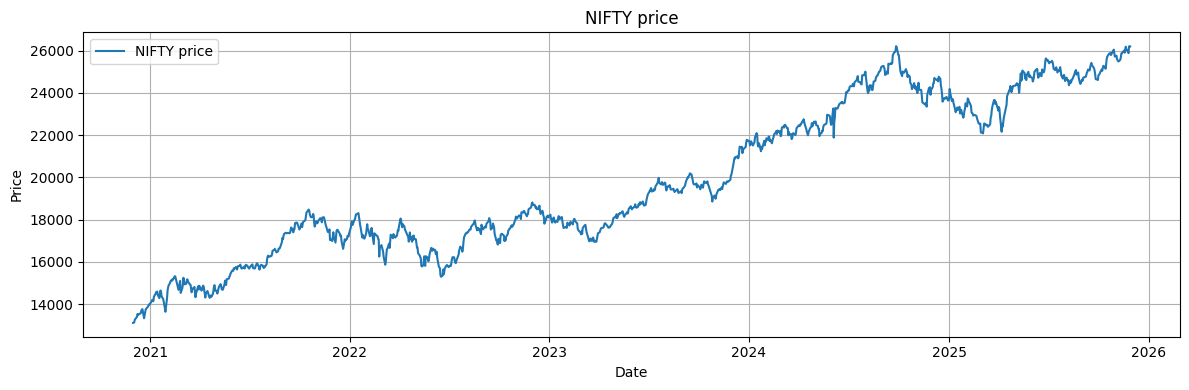

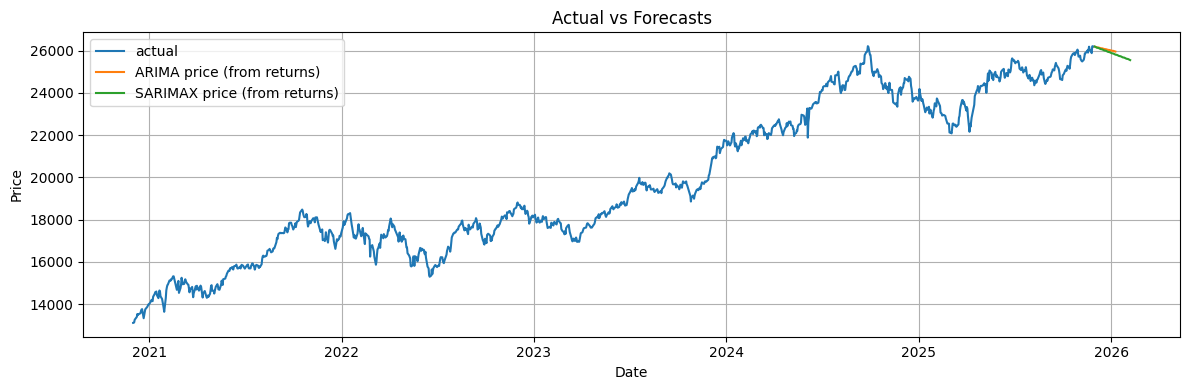

In [70]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
base=Path("/content/drive/MyDrive/AFM")
def read_nifty_file(p):
    df=pd.read_csv(p, engine="python", on_bad_lines="skip")
    if "Date" in df.columns:
        df.index = pd.to_datetime(df["Date"], errors="coerce")
    else:
        df.index = pd.to_datetime(df.iloc[:,0], errors="coerce")
    close_col = next((c for c in df.columns if "close" in c.lower() or "price" in c.lower()), df.columns[-1])
    df[close_col]=pd.to_numeric(df[close_col], errors="coerce")
    return df[[close_col]].rename(columns={close_col:"price"})
nifty_files=[f for f in sorted(base.iterdir()) if f.is_file() and "nifty" in f.name.lower() and f.suffix.lower()==".csv"]
parts=[]
for f in nifty_files:
    try:
        parts.append(read_nifty_file(f))
    except:
        pass
if not parts:
    raise SystemExit("no nifty csvs found")
series = pd.concat(parts).sort_index()
series = series[~series.index.duplicated(keep="last")]
series = series["price"].dropna()
if series.empty:
    raise SystemExit("no valid price data after parsing Date column")
print("series range:", series.index.min(), "to", series.index.max(), "count", len(series))
arima_path = base/"arima_forecast.csv"
sar_path = base/"sarimax_or_arima_forecast.csv"
def load_forecast(p):
    if not p.exists():
        return None
    f = pd.read_csv(p, index_col=0, engine="python", on_bad_lines="skip")
    if isinstance(f, pd.DataFrame) and f.shape[1]==1:
        s = f.iloc[:,0].squeeze()
    else:
        s = f.squeeze()
    try:
        s.index = pd.to_datetime(s.index, errors="coerce")
    except:
        s.index = pd.to_datetime(s.index.astype(str), errors="coerce")
    s = s[~s.index.duplicated(keep="first")]
    if s.index.isna().all() or (s.index.min().year <= 1970):
        last = series.index.max()
        idx = pd.bdate_range(start=last, periods=len(s)+1)[1:]
        s = pd.Series(np.asarray(s).astype(float), index=idx)
    return s
a = load_forecast(arima_path)
s = load_forecast(sar_path)
plt.figure(figsize=(12,4)); plt.plot(series, label="NIFTY price"); plt.title("NIFTY price"); plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()
plt.figure(figsize=(12,4)); plt.plot(series, label="actual")
if a is not None and not a.empty:
    if np.nanmax(np.abs(a.astype(float))) < 1:
        start_idx = a.index[0]
        last_price = series.loc[:start_idx].iloc[-1] if any(series.index<=start_idx) else series.iloc[-1]
        p = float(last_price); price_fore=[]
        for r in a:
            p = p*(1+float(r)); price_fore.append(p)
        apr = pd.Series(price_fore, index=a.index)
        plt.plot(apr, label="ARIMA price (from returns)")
    else:
        plt.plot(a, label="ARIMA forecast (price)")
if s is not None and not s.empty:
    if np.nanmax(np.abs(s.astype(float))) < 1:
        start_idx = s.index[0]
        last_price = series.loc[:start_idx].iloc[-1] if any(series.index<=start_idx) else series.iloc[-1]
        p = float(last_price); price_fore=[]
        for r in s:
            p = p*(1+float(r)); price_fore.append(p)
        spr = pd.Series(price_fore, index=s.index)
        plt.plot(spr, label="SARIMAX price (from returns)")
    else:
        plt.plot(s, label="SARIMAX forecast (price)")
plt.title("Actual vs Forecasts"); plt.xlabel("Date"); plt.ylabel("Price"); plt.grid(True); plt.legend(); plt.tight_layout(); plt.show()

In [66]:
import pandas as pd
base="/content/drive/MyDrive/AFM"
for f in ["arima_forecast.csv","sarimax_or_arima_forecast.csv","rolling_preds.csv","rolling_coeffs.csv","rolling_betas.csv","factor_contributions.csv"]:
    p=Path(base)/f
    if p.exists():
        print("----",f)
        print(pd.read_csv(p, index_col=0).head())

---- arima_forecast.csv
                                      0
1970-01-02 00:00:00.000000248 -0.000454
1970-01-03 00:00:00.000000248 -0.000307
1970-01-04 00:00:00.000000248 -0.000303
1970-01-05 00:00:00.000000248 -0.000303
1970-01-06 00:00:00.000000248 -0.000303
---- sarimax_or_arima_forecast.csv
                               predicted_mean
1970-01-01 00:00:00.000000199       -0.000277
1970-01-01 00:00:00.000000200       -0.000498
1970-01-01 00:00:00.000000201       -0.000504
1970-01-01 00:00:00.000000202       -0.000505
1970-01-01 00:00:00.000000203       -0.000505


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/p

Epoch 1/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 17s 161ms/step - loss: 0.0865
Epoch 2/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 5s 140ms/step - loss: 0.0018
Epoch 3/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 114ms/step - loss: 9.2663e-04
Epoch 4/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 63ms/step - loss: 9.1309e-04
Epoch 5/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.6281e-04
Epoch 6/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 9.9616e-04
Epoch 7/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.2701e-04
Epoch 8/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 49ms/step - loss: 8.2073e-04
Epoch 9/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - loss: 7.7560e-04
Epoch 10/10
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - loss: 8.1693e-04
saved to /content/drive/MyDrive/AFM/results


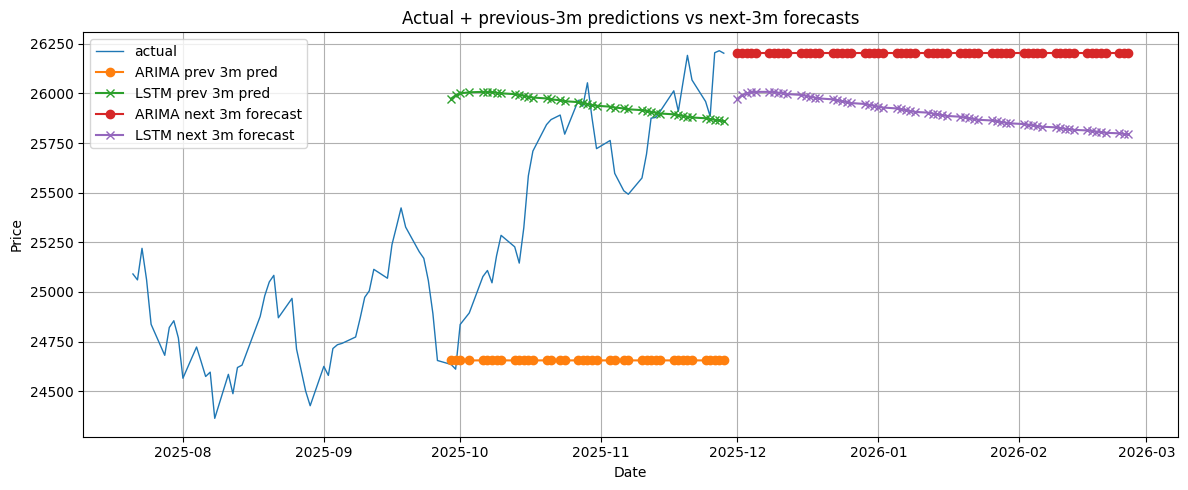

In [73]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense

base=Path("/content/drive/MyDrive/AFM")
nifty_files=[f for f in sorted(base.iterdir()) if f.is_file() and "nifty" in f.name.lower() and f.suffix.lower()==".csv"]
parts=[]
for f in nifty_files:
    try:
        t=pd.read_csv(f, engine="python", on_bad_lines="skip")
        if "Date" in t.columns:
            t.index=pd.to_datetime(t["Date"], errors="coerce")
        else:
            t.index=pd.to_datetime(t.iloc[:,0], errors="coerce")
        col=next((c for c in t.columns if "close" in c.lower() or "price" in c.lower()), t.columns[-1])
        t[col]=pd.to_numeric(t[col], errors="coerce")
        parts.append(t[[col]].rename(columns={col:"price"}))
    except:
        pass
series=pd.concat(parts).sort_index()
series=series[~series.index.duplicated(keep="last")]
series=series["price"].dropna()

horizon=63
back_window_days=180
end=series.index.max()
start_window=end - pd.Timedelta(days=back_window_days)
train_end_for_backtest=end - pd.Timedelta(days=horizon)
train_series = series.loc[:train_end_for_backtest]
test_actual = series.loc[train_end_for_backtest + pd.Timedelta(days=1):end]
if test_actual.empty:
    test_actual = series.iloc[-horizon:]
    train_series = series.iloc[:-horizon]

arima_model = ARIMA(train_series, order=(1,1,1)).fit()
prev_pred = arima_model.forecast(steps=len(test_actual))
full_model = ARIMA(series, order=(1,1,1)).fit()
future_pred = full_model.forecast(steps=horizon)

def idx_for_forecast(last_index, steps):
    start = pd.to_datetime(last_index)
    idx = pd.bdate_range(start=start, periods=steps+1)[1:]
    return idx

prev_idx = test_actual.index
future_idx = idx_for_forecast(series.index.max(), horizon)
prev_pred = pd.Series(prev_pred.values, index=prev_idx)
future_pred = pd.Series(future_pred.values, index=future_idx)

def rmse(a,b):
    a=np.asarray(a); b=np.asarray(b)
    return float(np.sqrt(np.nanmean((a-b)**2)))
m_prev = None
if len(prev_pred)>0 and len(test_actual.loc[prev_pred.index])==len(prev_pred):
    m_prev = rmse(test_actual.loc[prev_pred.index], prev_pred)

scaler=MinMaxScaler()
svals = series.values.reshape(-1,1)
s_scaled = scaler.fit_transform(svals)
lookback=60
def make_xy(arr):
    X=[]; y=[]
    for i in range(lookback, len(arr)):
        X.append(arr[i-lookback:i])
        y.append(arr[i])
    X=np.array(X); y=np.array(y)
    X=X.reshape((X.shape[0], X.shape[1], 1))
    return X, y
X_all, y_all = make_xy(s_scaled)
split_idx = len(series) - horizon - lookback
if split_idx<=0:
    split_idx = int(len(X_all)*0.8)
X_train = X_all[:split_idx]; y_train = y_all[:split_idx]
model = Sequential([Input(shape=(X_train.shape[1],1)), LSTM(50, return_sequences=True), LSTM(50), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)
def iter_forecast(model, last_window_scaled, steps, scaler):
    out=[]
    cur = last_window_scaled.copy()
    for _ in range(steps):
        pred = model.predict(cur.reshape(1,cur.shape[0],1), verbose=0)[0,0]
        out.append(pred)
        cur = np.concatenate([cur[1:], [[pred]]], axis=0)
    out = np.array(out).reshape(-1,1)
    return scaler.inverse_transform(out).flatten()
last_window = s_scaled[-lookback:].reshape(lookback,1)
lstm_prev_start_idx = len(series) - horizon - len(prev_pred)
if lstm_prev_start_idx < lookback:
    lstm_prev_start_idx = len(series) - horizon - lookback
lstm_last_window_for_prev = s_scaled[lstm_prev_start_idx + lookback - lookback: lstm_prev_start_idx + lookback].reshape(lookback,1)
lstm_prev_forecast = iter_forecast(model, s_scaled[-lookback:].reshape(lookback,1) if len(prev_pred)==0 else s_scaled[-lookback:], len(prev_pred), scaler) if len(prev_pred)>0 else np.array([])
lstm_future_forecast = iter_forecast(model, s_scaled[-lookback:].reshape(lookback,1), horizon, scaler)
if len(prev_pred)>0:
    lstm_prev_series = pd.Series(lstm_prev_forecast, index=prev_idx)
else:
    lstm_prev_series = pd.Series(dtype=float)
lstm_future_series = pd.Series(lstm_future_forecast, index=future_idx)

plot_start = start_window if start_window in series.index else series.index[-(back_window_days//2):].min()
plt.figure(figsize=(12,5))
plt.plot(series.loc[plot_start:], label="actual", linewidth=1)
if len(prev_pred)>0:
    plt.plot(prev_pred, label="ARIMA prev 3m pred", marker='o')
if len(lstm_prev_series)>0:
    plt.plot(lstm_prev_series, label="LSTM prev 3m pred", marker='x')
plt.plot(future_pred, label="ARIMA next 3m forecast", marker='o')
plt.plot(lstm_future_series, label="LSTM next 3m forecast", marker='x')
plt.title("Actual + previous-3m predictions vs next-3m forecasts")
plt.xlabel("Date"); plt.ylabel("Price"); plt.legend(); plt.grid(True); plt.tight_layout()
res_dir = base/"results"
res_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(res_dir/"final_combined_forecast.png")
pd.Series(prev_pred).to_csv(res_dir/"arima_prev_pred.csv")
pd.Series(future_pred).to_csv(res_dir/"arima_future_pred.csv")
pd.Series(lstm_prev_series).to_csv(res_dir/"lstm_prev_pred.csv")
pd.Series(lstm_future_series).to_csv(res_dir/"lstm_future_pred.csv")
if m_prev is not None:
    pd.DataFrame({"arima_prev_rmse":[m_prev]}).to_csv(res_dir/"arima_prev_metrics.csv")
print("saved to", str(res_dir))


Mounted at /content/drive


/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.12/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/u

Epoch 1/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 10s 91ms/step - loss: 0.0699
Epoch 2/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 84ms/step - loss: 0.0016
Epoch 3/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 132ms/step - loss: 9.3267e-04
Epoch 4/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 85ms/step - loss: 9.1576e-04
Epoch 5/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 49ms/step - loss: 9.1054e-04
Epoch 6/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - loss: 8.9090e-04
Epoch 7/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 8.6791e-04
Epoch 8/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - loss: 8.4669e-04
Epoch 9/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step - loss: 8.4320e-04
Epoch 10/10
37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 8.0922e-04


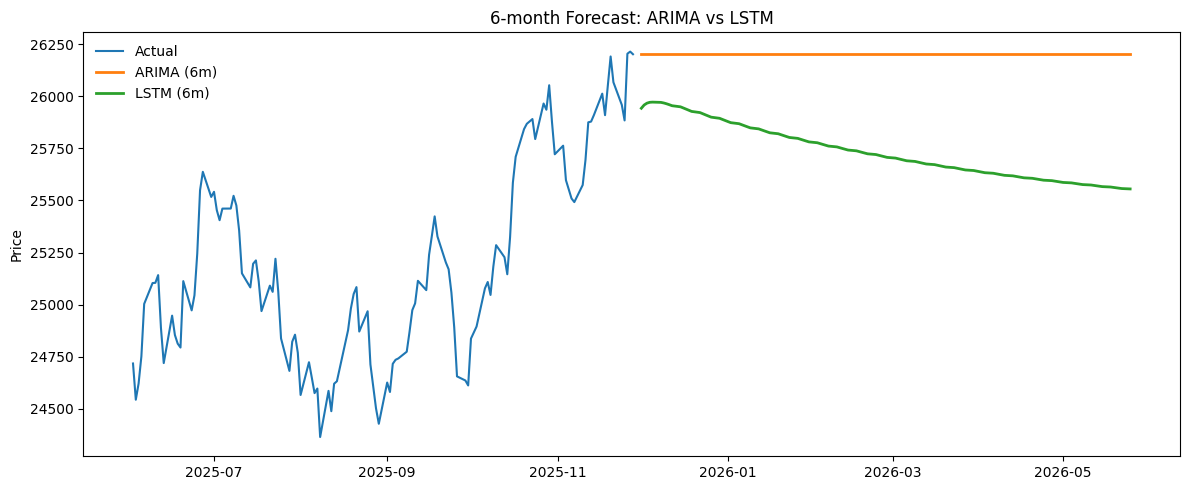

In [77]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import Sequential, Input
from tensorflow.keras.layers import LSTM, Dense

base=Path("/content/drive/MyDrive/AFM")
nfiles=[f for f in sorted(base.iterdir()) if f.is_file() and "nifty" in f.name.lower() and f.suffix.lower()==".csv"]
parts=[]
for f in nfiles:
    t=pd.read_csv(f, engine="python", on_bad_lines="skip")
    if "Date" in t.columns: t.index=pd.to_datetime(t["Date"], errors="coerce")
    else: t.index=pd.to_datetime(t.iloc[:,0], errors="coerce")
    col=next((c for c in t.columns if "close" in c.lower() or "price" in c.lower()), t.columns[-1])
    t[col]=pd.to_numeric(t[col], errors="coerce")
    parts.append(t[[col]].rename(columns={col:"price"}))
series=pd.concat(parts).sort_index()
series=series[~series.index.duplicated(keep="last")]
series=series["price"].dropna()

horizon_bd = 126
last_date = series.index.max()
future_idx = pd.bdate_range(start=last_date, periods=horizon_bd+1)[1:]

arima = ARIMA(series, order=(1,1,1)).fit()
arima_fore = arima.forecast(steps=horizon_bd)
arima_series = pd.Series(arima_fore.values, index=future_idx)

scaler=MinMaxScaler()
scaled = scaler.fit_transform(series.values.reshape(-1,1))
lookback=60
X=[]; y=[]
for i in range(lookback, len(scaled)):
    X.append(scaled[i-lookback:i])
    y.append(scaled[i])
X=np.array(X); y=np.array(y)
X=X.reshape((X.shape[0], X.shape[1], 1))
train_epochs=10
model=Sequential([Input(shape=(X.shape[1],1)), LSTM(50, return_sequences=True), LSTM(50), Dense(1)])
model.compile(optimizer='adam', loss='mse')
model.fit(X, y, epochs=train_epochs, batch_size=32, verbose=1)

last_window = scaled[-lookback:].reshape(lookback,1)
preds=[]
cur = last_window.copy()
for _ in range(horizon_bd):
    p = model.predict(cur.reshape(1,cur.shape[0],1), verbose=0)[0,0]
    preds.append(p)
    cur = np.concatenate([cur[1:], [[p]]], axis=0)
preds = np.array(preds).reshape(-1,1)
lstm_price = pd.Series(scaler.inverse_transform(preds).flatten(), index=future_idx)

plot_start = series.index.max() - pd.Timedelta(days=180)
plt.figure(figsize=(12,5))
plt.plot(series.loc[plot_start:], color='tab:blue', linewidth=1.5, label='Actual')
plt.plot(arima_series, color='tab:orange', linewidth=2, label='ARIMA (6m)')
plt.plot(lstm_price, color='tab:green', linewidth=2, label='LSTM (6m)')
plt.legend(frameon=False)
plt.xlabel('')
plt.ylabel('Price')
plt.title('6-month Forecast: ARIMA vs LSTM')
plt.tight_layout()
res_dir=base/"results"; res_dir.mkdir(parents=True, exist_ok=True)
plt.savefig(res_dir/"6m_arima_lstm.png", bbox_inches='tight')
plt.show()